In [3]:
%run "0. config.ipynb"

https://api.redmetrics.io/v1/event.csv?game=0fe53936-027f-461c-b087-b5b5737b2163&gameVersion=51b8a78a-8dd3-4a5e-9f41-01e6805e0f52&entityType=event
1866


# data preparation

In [21]:
list_types = list(df_raw.type.unique())

## counting number of events per player ~ game

In [6]:
def compute_players_type_events(logs):
  df = logs[["playerId", "type"]].copy()
  df["count"] = 1

  df = df.groupby(["playerId", "type"]).agg({ "count" : np.sum })

  df = df.unstack()
  df.columns = df.columns.droplevel()
  df = df.reset_index()
  df = df.fillna(0)
  df = df.set_index([ "playerId" ])
#   print len(df.index)
#   print df.columns
  
  return df

In [7]:
players_stats = compute_players_type_events(df_raw)

## compute game durations

In [8]:
def compute_game_durations(logs):

  df = logs.groupby("playerId").agg({ "serverTime": [ np.min, np.max  ] })

  df["duration"] = pd.to_datetime(df["serverTime"]["amax"]) - pd.to_datetime(df["serverTime"]["amin"])
  df["duration"] = df["duration"].map(lambda x: np.timedelta64(x, 's'))

  df = df.loc[:, [("duration", "")]]

  df.columns = df.columns.droplevel()
  df.columns = [ "duration (seconds)" ]

  df["duration (seconds)"] = df["duration (seconds)"].astype(int)/1000000000
  
  return df

In [9]:
players_stats = pd.merge(players_stats, compute_game_durations(df_raw), left_index=True, right_index=True)

## compute max checkpoint reached by players

In [51]:
def max_reach(x):
  checkpoints = [ int(checkpoint[-2:]) for checkpoint in x if checkpoint != np.nan and not isinstance(checkpoint, float)]
  
  # print checkpoints
  
  if len(checkpoints) > 0:
    return max([ int(checkpoint[-2:]) for checkpoint in x if checkpoint != np.nan and not isinstance(checkpoint, float)])
  else:
    return 0

def compute_max_reachpoint(logs):
  df = logs.loc[:, ["playerId", "type", "section"]].groupby("playerId").agg({ "section": max_reach })
  
  return df

compute_max_reachpoint(df_raw[0:500]).head()

,section
playerId,
0306db66-081d-4035-b30f-8358469d6ec3,8
09298114-1161-476c-8243-915709d6056e,7
0be21833-f660-4b7e-9ce5-fc5acf981d8f,3
10780614-9c63-4cdf-b0c0-4e77c6d2d9c1,0
15086510-8422-4d25-b345-cf2760b3e48d,0


In [52]:
players_stats = pd.merge(players_stats, compute_max_reachpoint(df_raw), left_index=True, right_index=True)

## preview

In [53]:
players_stats.head()

,complete,configure,craft,death,equip,gotomooc,gotourl,pickup,reach,restart,selectmenu,start,switch,unequip,duration (seconds),section
playerId,,,,,,,,,,,,,,,,
0023dbb1-7f98-4cdb-8122-722f801f40b3,0,1,0,3,0,0,0,1,2,0,1,0,0,0,175,2
01b0c435-f0c0-4bfd-9189-86fc0d29b163,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
02bc076b-32aa-467a-bbc6-b746abedb7bd,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
02c6953a-0417-4858-8efb-1989be9f6b9d,0,1,0,0,0,0,0,0,1,0,2,1,1,0,19,1
0306db66-081d-4035-b30f-8358469d6ec3,1,0,3,17,8,0,1,5,12,1,2,0,0,2,1030,8


In [54]:
players_stats.to_csv("data/players_stats.csv")

# PCA YOLO

In [12]:
from sklearn.decomposition import PCA

In [55]:
players_stats.mean()

complete                0.156028
configure               0.205674
craft                   0.312057
death                   4.198582
equip                   1.347518
gotomooc                0.007092
gotourl                 0.070922
pickup                  1.049645
reach                   3.425532
restart                 0.014184
selectmenu              1.184397
start                   0.680851
switch                  0.191489
unequip                 0.390071
duration (seconds)    570.815603
section                 2.773050
dtype: float64

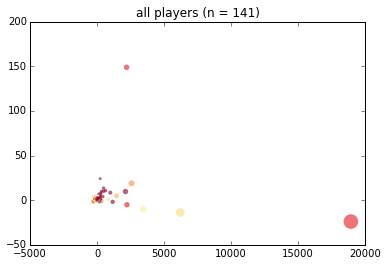

In [80]:
X = players_stats.as_matrix()
n = X.shape[0]

pca = PCA(n_components=2)
X_r = pca.fit(X).transform(X)

cmap = plt.get_cmap("YlOrRd")

X_std = 20 * players_stats["duration (seconds)"] / players_stats["duration (seconds)"].std()
X_color = cmap(players_stats["section"]/8)

#print X_color

plt.figure()
plt.scatter(X_r[:, 0], X_r[:, 1], s=X_std, c=X_color, alpha=.6, lw=0) #, c=c, label=target_name)
plt.title("all players (n = %s)" % (n))
plt.legend()


we skipped gotomooc because there is no enough data


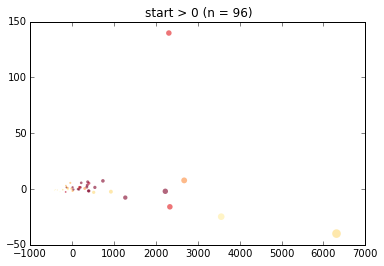

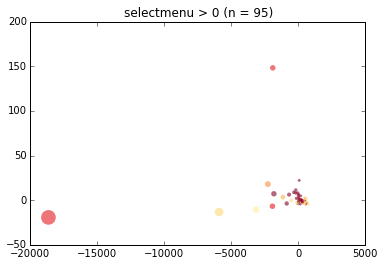

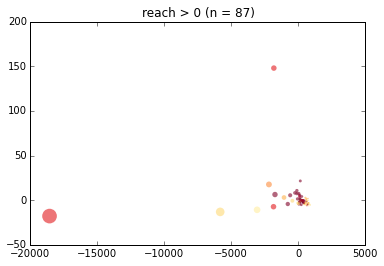

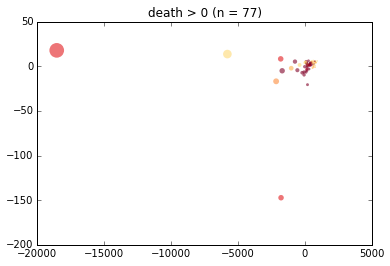

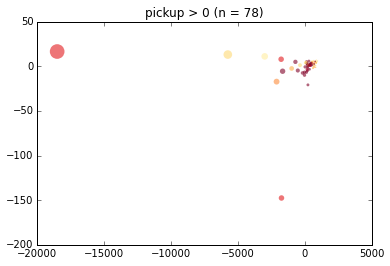

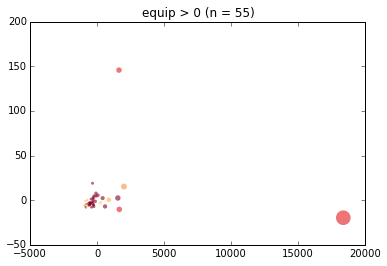

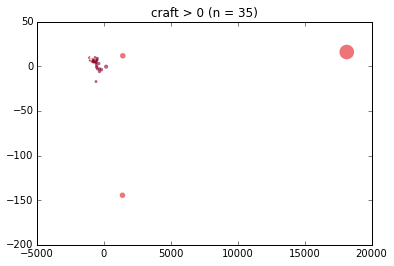

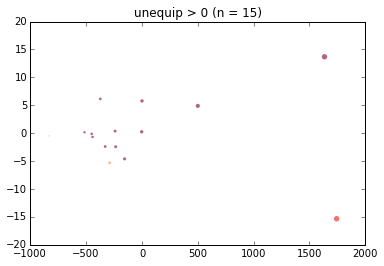

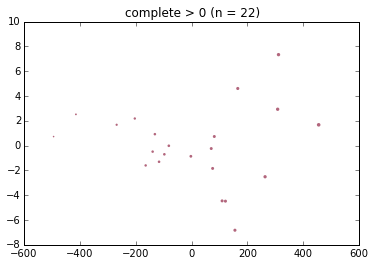

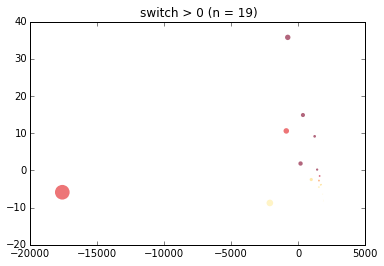

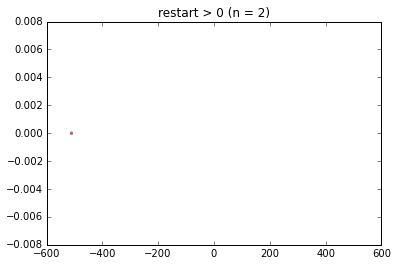

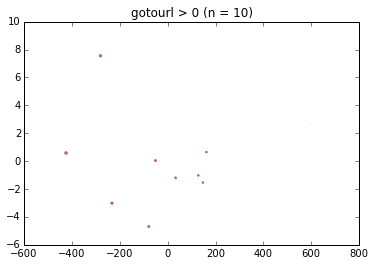

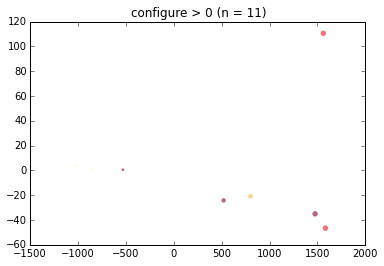

In [81]:
for title in list_types:
  df = players_stats[ players_stats[title] > 0 ] 
  
  X = df.as_matrix()
  n = X.shape[0]
  
  # print X
  # print n
  
  if n > 1:
    pca = PCA(n_components=2)
    X_r = pca.fit(X).transform(X)

    d = X_std[df.index]
    c = cmap(df["section"]/8)

    
    plt.figure()
    plt.scatter(X_r[:, 0], X_r[:, 1], s=d, c=c, alpha=.6 , lw=0) #, c=c, label=target_name)
    plt.title("%s > 0 (n = %s)" % (title, n))
    plt.legend()
  else:
    print "we skipped %s because there is no enough data" % title

plt.show();

(array([ 64.,  27.,   3.,   8.,   9.,  22.,   5.,   1.,   0.,   0.,   0.,
          1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.]),
 array([  0. ,   1.6,   3.2,   4.8,   6.4,   8. ,   9.6,  11.2,  12.8,
         14.4,  16. ,  17.6,  19.2,  20.8,  22.4,  24. ,  25.6,  27.2,
         28.8,  30.4,  32. ]),
 <a list of 20 Patch objects>)

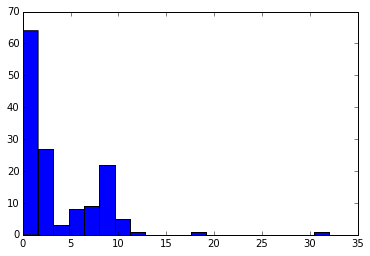

In [17]:
plt.hist(players_stats["reach"], bins=20)